# **Brain Abnormality Classification**



**Full name:** Alireza Sabounchi

**Student Number:** 401212454

In this exercise we are going to train a CNN-based model for a multi-class classification task, brain abnormality classification. The dataset we are going to use is a small imbalanced one that contains MRIs of both normal and abnormal brains.
We will learn how to use and refine models that have been already trained on some other rich datasets to deal with situations in which we don't have access to good datasets or powerful hardware.
This exercise has been broken into some smaller sections and each section has its score. What you are supposed to do is shown in `"======== TODO ========"` format. Any part which is showed by `...` should be completed. with There may be some **Questions** in the notes below. It is not necessary to answer these questions, but they will help you to do the next sections.

# Imports

First of all we need to import required libraries.

In [2]:
from __future__ import print_function
from __future__ import division
import imgaug
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import shutil
import os
import random
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


# 1) Data Preparation:

## 1.1) Download Dataset

The following pieces of code will download dataset to your colab storage and remove corrupted or useless files.

In [3]:
!wget --content-disposition https://figshare.com/ndownloader/files/28399209
!mkdir dataset
!tar xvf NINS_Dataset.tar --directory dataset/

Streaming output truncated to the last 5000 lines.
./Brain Infection with abscess/58211497.jpg
./Brain Infection with abscess/58211513.jpg
./Brain Infection with abscess/58211529.jpg
./Brain Infection with abscess/58211545.jpg
./Brain Infection with abscess/58211561.jpg
./Brain Infection with abscess/58211577.jpg
./Brain Infection with abscess/58211593.jpg
./Brain Infection with abscess/58211609.jpg
./Brain Infection with abscess/97887252.jpg
./Brain Infection with abscess/97887268.jpg
./Brain Infection with abscess/97887284.jpg
./Brain Infection with abscess/97887300.jpg
./Brain Infection with abscess/97887316.jpg
./Brain Infection with abscess/97887332.jpg
./Brain Infection with abscess/97887348.jpg
./Brain Infection with abscess/97887364.jpg
./Brain Infection with abscess/97887380.jpg
./Brain Infection with abscess/97887396.jpg
./Brain Infection with abscess/97887412.jpg
./Brain Infection with abscess/97887428.jpg
./Brain Infection with abscess/97887444.jpg
./Brain Infection with ab

In [4]:
# Set the directory containing the images
data_dir = 'dataset/'

classes = os.listdir(data_dir)
shutil.rmtree(os.path.join(data_dir, 'models'))
classes = os.listdir(data_dir)

for c in classes:
    images = os.listdir(os.path.join(data_dir, c))
    for image in images:
      if image[-4:] != '.jpg':
        corrupted_img = os.path.join(data_dir, c, image)
        try:
          os.remove(corrupted_img)
        except:
          shutil.rmtree(corrupted_img)

## 1.2) Splitting Dataset: 5

The data should be spilitted into three groups: train, validation, and test. The groups' size are your choice and they should be reasonable, but it is recommended to use 0.8, 0.1, and 0.1 for train, validation, and test, respectively.

In [5]:
# Set up directories and data splits
from math import floor

root_dir = 'dataset'
classes = os.listdir(root_dir)

# Set the split ratio for train, validation and test
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Create a dictionary with images and labels
data_dict = {}
for idx, class_name in enumerate(classes):
    class_dir = os.path.join(root_dir, class_name)
    data_dict[class_name] = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

# Create train, validation and test splits
train_images = []
val_images = []
test_images = []
for cls_name, images in data_dict.items():
    n_images = len(images)
    n_train = floor(n_images * train_split)
    n_val = floor(n_images * val_split)
    n_test = n_images - n_train - n_val

    train_images.extend(images[:n_train])
    val_images.extend(images[n_train:n_train+n_val])
    test_images.extend(images[n_train+n_val:])

    print(f'Class: {cls_name}, Total: {n_images}, Train: {n_train}, Validation: {n_val}, Test: {n_test}')

Class: Stroke(infarct), Total: 906, Train: 634, Validation: 135, Test: 137
Class: Hemorrhagic collection, Total: 38, Train: 26, Validation: 5, Test: 7
Class: Post-operative Status with Small Hemorrhage, Total: 38, Train: 26, Validation: 5, Test: 7
Class: Brain Atrophy, Total: 264, Train: 184, Validation: 39, Test: 41
Class: Brain tumor (Astrocytoma Ganglioglioma), Total: 38, Train: 26, Validation: 5, Test: 7
Class: Glioma, Total: 76, Train: 53, Validation: 11, Test: 12
Class: Ischemic change  demyelinating plaque, Total: 38, Train: 26, Validation: 5, Test: 7
Class: Obstructive Hydrocephalus, Total: 76, Train: 53, Validation: 11, Test: 12
Class: cerebral venous sinus thrombosis, Total: 76, Train: 53, Validation: 11, Test: 12
Class: Brain Tumor (Hemangioblastoma  Pleomorphic xanthroastrocytoma  metastasis), Total: 74, Train: 51, Validation: 11, Test: 12
Class: Brain tumor operated with ventricular hemorrhage, Total: 76, Train: 53, Validation: 11, Test: 12
Class: Brain tumor - Recurrencer

**Question:** How many classes are there in your dataset?

**Question:** Did you notice the imbalance between classes?

We put samples of each group in a seperate folder.

In [6]:
!mkdir train val test

n_img = 0
for image in train_images:
  n_img += 1
  os.makedirs(os.path.join('train', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('train', *image.split('/')[1:]))

for image in val_images:
  os.makedirs(os.path.join('val', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('val', *image.split('/')[1:]))

for image in test_images:
  os.makedirs(os.path.join('test', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('test', *image.split('/')[1:]))

## 1.3) Calculate Weights of Calsses: 5

As you saw there exists an imbalance between classes. The dataset contains a class with more than a thousand samples and classes with fewer than 50 samples.

Here we want to calculate coefficients (weights) that can compensate this gap. So you are supposed to calculate these coefficients for each class such that if you multiply a class size by its corresponding coefficient the result will be equal for all the other classes. The minimum value of a coefficient should be 1.

In [7]:
wgts = []
max_class_size = max([len(data_dict[c]) for c in classes])

for c in classes:
    print(c)
    class_size = len(data_dict[c])
    class_weight = max_class_size / class_size
    wgts.append(class_weight)

    print(f'Size of Class: {class_size}')
    print(f'Weight of Class: {class_weight}')
    print()

wgts = torch.Tensor(wgts)

Stroke(infarct)
Size of Class: 906
Weight of Class: 1.9304635761589404

Hemorrhagic collection
Size of Class: 38
Weight of Class: 46.026315789473685

Post-operative Status with Small Hemorrhage
Size of Class: 38
Weight of Class: 46.026315789473685

Brain Atrophy
Size of Class: 264
Weight of Class: 6.625

Brain tumor (Astrocytoma Ganglioglioma)
Size of Class: 38
Weight of Class: 46.026315789473685

Glioma
Size of Class: 76
Weight of Class: 23.013157894736842

Ischemic change  demyelinating plaque
Size of Class: 38
Weight of Class: 46.026315789473685

Obstructive Hydrocephalus
Size of Class: 76
Weight of Class: 23.013157894736842

cerebral venous sinus thrombosis
Size of Class: 76
Weight of Class: 23.013157894736842

Brain Tumor (Hemangioblastoma  Pleomorphic xanthroastrocytoma  metastasis)
Size of Class: 74
Weight of Class: 23.635135135135137

Brain tumor operated with ventricular hemorrhage
Size of Class: 76
Weight of Class: 23.013157894736842

Brain tumor - Recurrenceremnant of previo

## 1.4) Create DataLoaders: 5

We read and put the data of each group in its corresponding list.

In [8]:
train_images = []
train_aug_images = []
val_images = []
test_images = []

for c in classes:
    class_dir = os.path.join('train', c)
    train_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('val', c)
    val_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('test', c)
    test_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

Define required transforms and create Dataloaders.

**Question:** What is the approperiate input size of models like ResNet, VGG, etc.? Becarefull about the size of your images as well.

**Notice:** Select a suitable batch size.

**Notice:** Becarefull about the range of input values. They should be in [0, 1).

In [9]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_list, classes=None, transform=None):
        self.image_list = image_list
        self.transform = transform
        self.label_encoder = {c: i for (i, c) in enumerate(classes)}

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image = Image.open(self.image_list[index])

        if self.transform is not None:
            image = self.transform(image)

        label = self.image_list[index].split('/')[-2]
        label = self.label_encoder[label]

        return image, label


############## To Do ##############
input_size = 224
batch_size = 32
# Define the transformations to be applied on the train and validation sets
transforms = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets using defined CustomDataset class
train_dataset = CustomDataset(train_images, classes=classes, transform=transforms)
val_dataset = CustomDataset(val_images, classes=classes, transform=transforms)
test_dataset = CustomDataset(test_images, classes=classes, transform=transforms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
###################################

In [10]:
data_loaders = {'train': train_loader, 'val': val_loader}
num_cls = ... # Number of classes

## 1.2) Data Visualization

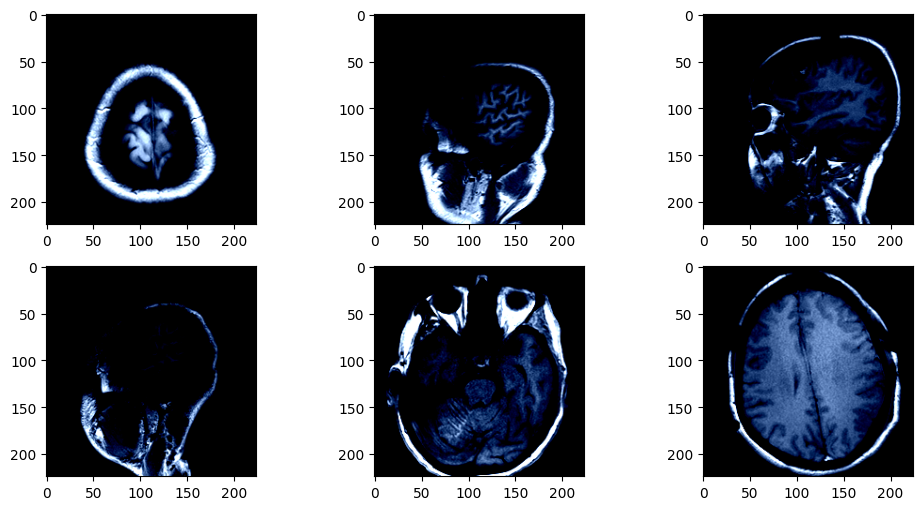

In [11]:
fig, axis = plt.subplots(2, 3, figsize=(12, 6))
for i, batch in enumerate(train_loader):
  axis[0, 0].imshow(np.array(batch[0][0]).transpose(1, 2, 0))
  axis[0, 1].imshow(np.array(batch[0][1]).transpose(1, 2, 0))
  axis[0, 2].imshow(np.array(batch[0][2]).transpose(1, 2, 0))
  axis[1, 0].imshow(np.array(batch[0][-3]).transpose(1, 2, 0),)
  axis[1, 1].imshow(np.array(batch[0][-2]).transpose(1, 2, 0),)
  axis[1, 2].imshow(np.array(batch[0][-1]).transpose(1, 2, 0),)
  break

# 2) Model Initialization and Structure Modification


## 2.1) ResNet50: 10

Load ResNet50 model with its pretrained weights. (Suggestion: IMAGENET1K_V2)

In [12]:
# Load ResNet50 model with its pretrained weights
resnet_model = models.resnet50(pretrained=True)

# Print the structure of the loaded model
print(resnet_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 330MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [13]:
# Modify the classification part of the model
num_classes = len(classes)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

# Print the structure of the modified model and notice the difference
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

## 2.2) VGG16: 10

Load VGG16 model with its pretrained parameters. (Suggestion: IMAGENET1K_V1)

In [15]:
# Load VGG16 model with its pretrained weights
vgg_model = models.vgg16(pretrained=True)

# Print the structure of the loaded model
print(vgg_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 287MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [16]:
# Modify the classification part of the model
num_classes = len(classes)
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, num_classes)

# Print the structure of the modified model and notice the difference
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg_model = vgg_model.to(device)

# 3) Train Function: 15

Define your loss function for multi class classification. Don't forget to add class weights to it.

In [18]:
wgts = wgts.to(device)

############## To Do ##############
# Define the loss function for multi-class classification
criterion = nn.CrossEntropyLoss(weight=wgts)
###################################

Here you should define your main train function.

**Note1:** Since you are going to change the data during the training procedure, your train function have to get dataloaders as input.

**Note2:** Also you don't know how many epochs you should train.
  So save the best weights according to validation loss at the end of each epoch,
  and after the end of training, load the best model.

**Note3:** Save loss and accuracy of train and validation in each epoch to plot them later.

**Note4:** The following code is an template that can help you, but any other functions that you define with the desired properties is acceptable.


In [19]:
############## To Do ##############
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10):
    since = time.time()

    acc_hist = { 'train': [], 'val': [] }
    loss_hist = { 'train': [], 'val': [] }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # Calculate outputs and predictions
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    # Calculate loss
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'val' and scheduler is not None:
                scheduler.step(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            acc_hist[phase].append(epoch_acc)
            loss_hist[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights with the stored state dictionary
    model.load_state_dict(best_model_wts)

    return model, acc_hist, loss_hist
###################################

# 4) Feature Extraction


In this section with just update parameters of the recently modified layer(s).

### 4.1) ResNet50

### 4.1.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [20]:
############## To Do ##############
# Freeze all the parameters of the model
for param in resnet_model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the last fully connected layer
for param in resnet_model.fc.parameters():
    param.requires_grad = True
###################################

### 4.1.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [21]:
############## To Do ##############
from torch.optim import Adam

# Set the learning rate
learning_rate = 0.001

# Create an optimizer that only updates the parameters of the last fully connected layer
resnet_optimizer = Adam(resnet_model.fc.parameters(), lr=learning_rate)

lr_scheduler = None

In [ ]:
############## To Do ##############
num_epochs = 10
dataloaders = {'train': train_loader, 'val': val_loader}

resnet_fe, resnet_acc_fe, resnet_loss_fe = train_model(
    resnet_model,
    dataloaders,
    criterion,
    resnet_optimizer,
    lr_scheduler,
    num_epochs=num_epochs
)
###################################

Epoch 1/10
----------


### 4.2) VGG16

### 4.2.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [ ]:
############## To Do ##############
# Freeze all the parameters of the model
for param in vgg_model.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the last fully connected layer
for param in vgg_model.classifier[6].parameters():
    param.requires_grad = True
###################################

### 4.2.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [ ]:
############## To Do ##############
# Set the learning rate
learning_rate = 0.001
# Create an optimizer that only updates the parameters of the last fully connected layer
vgg_optimizer = Adam(vgg_model.classifier[6].parameters(), lr=learning_rate)
###################################

lr_scheduler = None

In [ ]:
############## To Do ##############
num_epochs = 10
dataloaders = {'train': train_loader, 'val': val_loader}

vgg_fe, vgg_acc_fe, vgg_loss_fe = train_model(
    vgg_model,
    dataloaders,
    criterion,
    vgg_optimizer,
    lr_scheduler,
    num_epochs=num_epochs
)
###################################

# 5) Fine-Tuning


In this section the whole parameters of the model are going to be updated.

## 5.1) ResNet50

### 5.1.1) Unfreezing

Unfreeze all the parameters.

In [ ]:
############## To Do ##############
# Unfreeze all the parameters of the model
for param in resnet_model.parameters():
    param.requires_grad = True
###################################

### 5.1.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [ ]:
############## To Do ##############

# Set the learning rate
learning_rate = 1e-5

# Create an optimizer that updates all the parameters of the model
resnet_optimizer = Adam(resnet_model.parameters(), lr=learning_rate)

lr_scheduler = None

num_epochs = 10
dataloaders = {'train': train_loader, 'val': val_loader}

resnet_ft, resnet_acc_ft, resnet_loss_ft = train_model(
    resnet_model,
    dataloaders,
    criterion,
    resnet_optimizer,
    lr_scheduler,
    num_epochs=num_epochs
)
###################################

## 5.2) VGG16

### 5.2.1) Unfreezing

Unfreeze all the parameters.

In [ ]:
############## To Do ##############
# Unfreeze all the parameters of the model
for param in vgg_model.parameters():
    param.requires_grad = True
###################################

### 5.2.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [ ]:
############## To Do ##############
# Set the learning rate
learning_rate = 1e-5

# Create an optimizer that updates all the parameters of the model
vgg_optimizer = Adam(vgg_model.parameters(), lr=learning_rate)

lr_scheduler = None

num_epochs = 5
dataloaders = {'train': train_loader, 'val': val_loader}

vgg_ft, vgg_acc_ft, vgg_loss_ft = train_model(
    vgg_model,
    dataloaders,
    criterion,
    vgg_optimizer,
    lr_scheduler,
    num_epochs=num_epochs
)
###################################

## 6) Plot Learning Curves: 5

Put the results of feature extraction and fine-tuning together and plot 2 figures for each of the models: accuracy and loss against epochs, i.e. 4 figures at all. Plot validation and train in one figure. Plot a vertical line that distinguish between feature extraction and fine-tuning epochs.

In [ ]:
############## To Do ##############
import matplotlib.pyplot as plt

def plot_acc_loss(acc_hist, loss_hist, title):
    num_epochs = len(acc_hist['train'])
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    train_acc = [x.cpu() for x in acc_hist['train']]
    plt.plot(epochs, train_acc, label='Train')
    val_acc = [x.cpu() for x in acc_hist['val']]
    plt.plot(epochs, val_acc, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss_hist['train'], label='Train')
    plt.plot(epochs, loss_hist['val'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(title)

# Plot accuracy and loss for frozen ResNet50
plot_acc_loss(resnet_acc_fe, resnet_loss_fe, 'Frozen ResNet50')

# Plot accuracy and loss for fine-tuned ResNet50
plot_acc_loss(resnet_acc_ft, resnet_loss_ft, 'Fine-tuned ResNet50')

# Plot accuracy and loss for frozen VGG16
plot_acc_loss(vgg_acc_fe, vgg_loss_fe, 'Frozen VGG16')

# Plot accuracy and loss for fine-tuned VGG16
plot_acc_loss(vgg_acc_ft, vgg_loss_ft, 'Fine-tuned VGG16')

plt.show()

###################################

## 7) Confusion Matrix: 5

Plot confusion matrix for each of the models. It should be a `num_of_classes * num_of_classes` square.

In [ ]:
############## To Do ##############
import seaborn as sns
def plot_confusion_matrix(model, dataloader):
    # Set model to evaluation mode
    model.eval()

    # Get true and predicted labels
    y_true = []
    y_pred = []
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

# Plot confusion matrix for ResNet50
plot_confusion_matrix(resnet_model, val_loader)
plt.title('ResNet50')

# Plot confusion matrix for VGG16
plot_confusion_matrix(vgg_model, val_loader)
plt.title('VGG16')

plt.show()
###################################

# 9) Evaluate on Test Split: 10

Calculate the accuracy of each model on test data and also plot confusion matrix for both of them.

In [ ]:
############## To Do ##############
def evaluate_model(model, dataloader):
    # Set model to evaluation mode
    model.eval()

    # Get true and predicted labels
    y_true = []
    y_pred = []
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    # Calculate accuracy
    accuracy = sum([y1 == y2 for y1, y2 in zip(y_true, y_pred)]) / len(y_true)

    return accuracy

# Evaluate ResNet50 on test data
resnet_test_acc = evaluate_model(resnet_model, test_loader)
print(f'ResNet50 Test Accuracy: {resnet_test_acc:.4f}')

# Plot confusion matrix for ResNet50
plt.figure()
plot_confusion_matrix(resnet_model, test_loader)
plt.title('ResNet50')

# Evaluate VGG16 on test data
vgg_test_acc = evaluate_model(vgg_model, test_loader)
print(f'VGG16 Test Accuracy: {vgg_test_acc:.4f}')

# Plot confusion matrix for VGG16
plt.figure()
plot_confusion_matrix(vgg_model, test_loader)
plt.title('VGG16')

plt.show()
###################################